# Soil–Structure Interaction

This example originates from the GitHub repository maintained by Professor Quan Gu of Xiamen University. 
Refer to: [OpenSeesXMU](https://github.com/OpenSeesXMU/OpenSees-examples-Chinese/tree/master/1.5-SSI)

In [1]:
import matplotlib.pyplot as plt
import openseespy.opensees as ops

import opstool as opst
import opstool.vis.pyvista as opsvis

The TCL script has been translated into a Python script using [opstool.pre.tcl2py](https://opstool.readthedocs.io/en/latest/src/api/_autosummary/opstool.pre.tcl2py.html#opstool.pre.tcl2py). 
For details, see: [model.py](https://github.com/yexiang1992/opstool/blob/master/docs/examples/post/SSI-GUQUAN/model.py)

In [2]:
from model import Model

Model()

## Visualize the model

Here, ``notebook=True`` and ``jupyter_backend="jupyterlab"`` are used solely for the purpose of documentation generation. You can disable them during actual use.

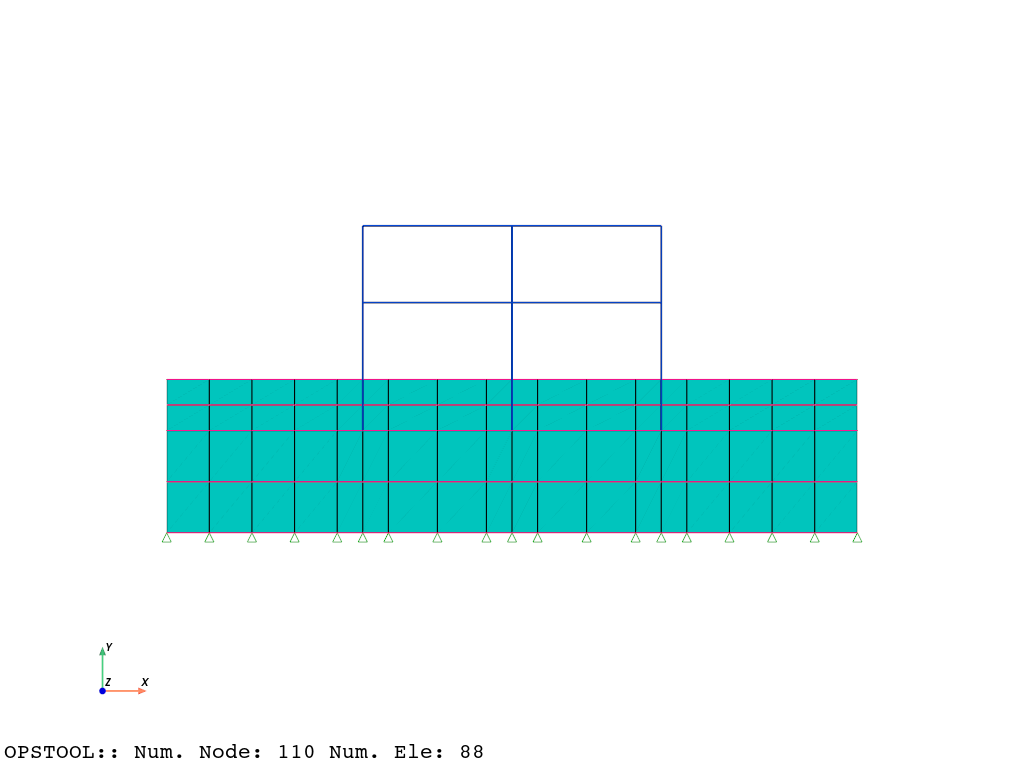

In [3]:
opsvis.set_plot_props(notebook=True)  # notebook=False should be used
fig = opst.vis.pyvista.plot_model()
fig.show(jupyter_backend="jupyterlab")  # fig.show() should be used for notebook=False

## Gravity analysis

In [4]:
ops.constraints("Transformation")
ops.numberer("RCM")
ops.test("NormDispIncr", 1e-06, 25, 2)
ops.integrator("LoadControl", 1, 1, 1, 1)
ops.algorithm("Newton")
ops.system("BandGeneral")
ops.analysis("Static")
ops.analyze(3)
print("soil gravity nonlinear analysis completed ...")

soil gravity nonlinear analysis completed ...


CTestNormDispIncr::test() - iteration: 6 current Norm: 2.68477e-11 (max: 1e-06, Norm deltaR: 6.07089e-11)
CTestNormDispIncr::test() - iteration: 1 current Norm: 1.49834e-16 (max: 1e-06, Norm deltaR: 6.91778e-11)
CTestNormDispIncr::test() - iteration: 1 current Norm: 1.47098e-16 (max: 1e-06, Norm deltaR: 8.07018e-11)


## Earthquake analysis

In [5]:
ops.timeSeries("Path", 1, "-dt", 0.01, "-filePath", "elcentro.txt", "-factor", 3)
ops.pattern("UniformExcitation", 1, 1, "-accel", 1)

In [6]:
ops.wipeAnalysis()
ops.constraints("Transformation")
ops.test("NormDispIncr", 1e-06, 25)
ops.algorithm("Newton")
ops.numberer("RCM")
ops.system("BandGeneral")
ops.integrator("Newmark", 0.55, 0.275625)
ops.analysis("Transient")

In [7]:
ODB = opst.post.CreateODB(
    odb_tag=1,
    compute_mechanical_measures=True,  # compute stress measures, strain measures, etc.
    project_gauss_to_nodes="copy",  # project gauss point responses to nodes, optional ["copy", "average", "extrapolate"]
)  # Create ODB object

for _ in range(2400):
    ops.analyze(1, 0.005)
    ODB.fetch_response_step()  # Fetch response for the current step
ODB.save_response(zlib=True)  # Save response

OPSTOOL ::  All responses data with _odb_tag = 1 saved in .opstool.output/RespStepData-1.nc!

## Post-processing

### Frame Element Response

In [8]:
FrameResp = opst.post.get_element_responses(odb_tag=1, ele_type="Frame")

OPSTOOL ::  Loading Frame response data from .opstool.output/RespStepData-1.nc ...

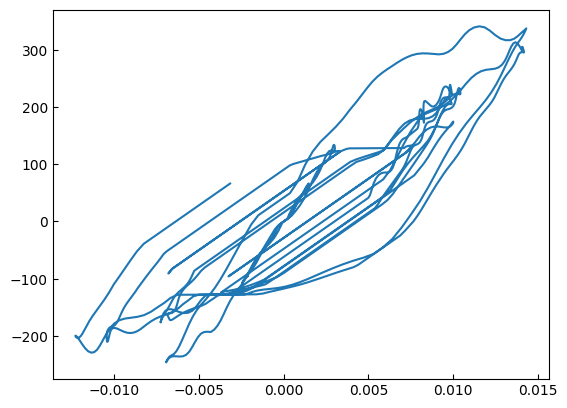

In [9]:
f = FrameResp["sectionForces"].sel(eleTags=7, secDofs="MZ", secPoints=1)
d = FrameResp["sectionDeformations"].sel(eleTags=7, secDofs="MZ", secPoints=1)

plt.plot(d, f)
plt.show()

### Nodal response

In [10]:
NodalResp = opst.post.get_nodal_responses(odb_tag=1)

OPSTOOL ::  Loading all response data from .opstool.output/RespStepData-1.nc ...

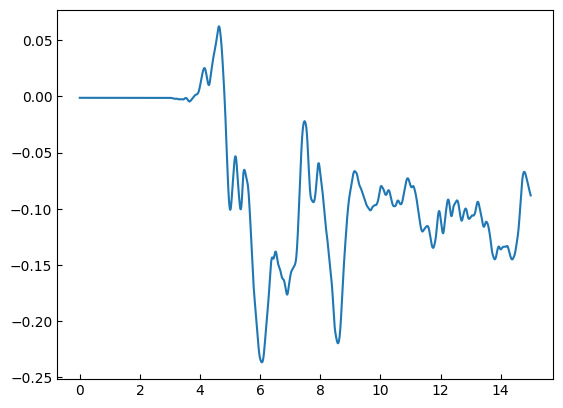

In [11]:
time = NodalResp.time
disp = NodalResp["disp"].sel(nodeTags=1, DOFs="UX")

plt.plot(time, disp)
plt.show()

### Plane Soil Element

In [12]:
PlaneResp = opst.post.get_element_responses(odb_tag=1, ele_type="Plane")

OPSTOOL ::  Loading Plane response data from .opstool.output/RespStepData-1.nc ...

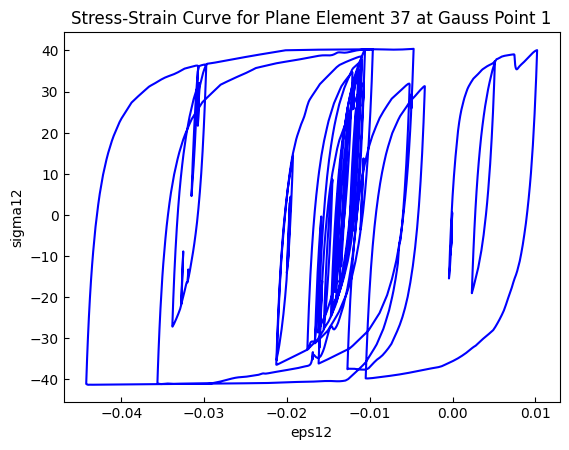

In [13]:
s = PlaneResp["Stresses"].sel(eleTags=37, GaussPoints=1, stressDOFs="sigma12")
e = PlaneResp["Strains"].sel(eleTags=37, GaussPoints=1, strainDOFs="eps12")

plt.plot(e, s, c="blue")
plt.xlabel("eps12")
plt.ylabel("sigma12")
plt.title("Stress-Strain Curve for Plane Element 37 at Gauss Point 1")
plt.show()

### Plotting the nodal responses with deformed shape

In [14]:
opsvis.set_plot_props(
    cmap="Spectral_r",
    point_size=0.0,
    notebook=True,
    scalar_bar_kargs={"title_font_size": 12, "label_font_size": 12, "position_x": 0.865},
    show_mesh_edges=False,
)

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

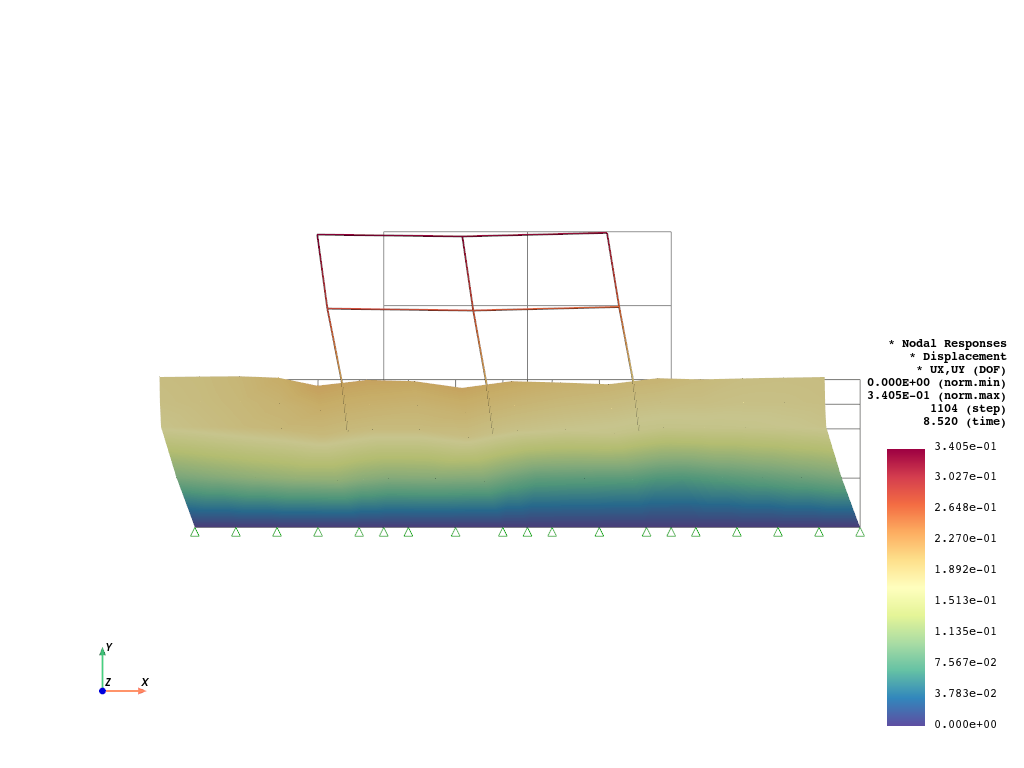

In [15]:
fig = opst.vis.pyvista.plot_nodal_responses(
    odb_tag=1,
    slides=False,
    step="absMax",
    resp_type="disp",
    resp_dof=("UX", "UY"),
    show_defo=True,
    scale=1.5,
    show_undeformed=True,
)
fig.show(jupyter_backend="jupyterlab")

### Plotting the plane element stresses

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

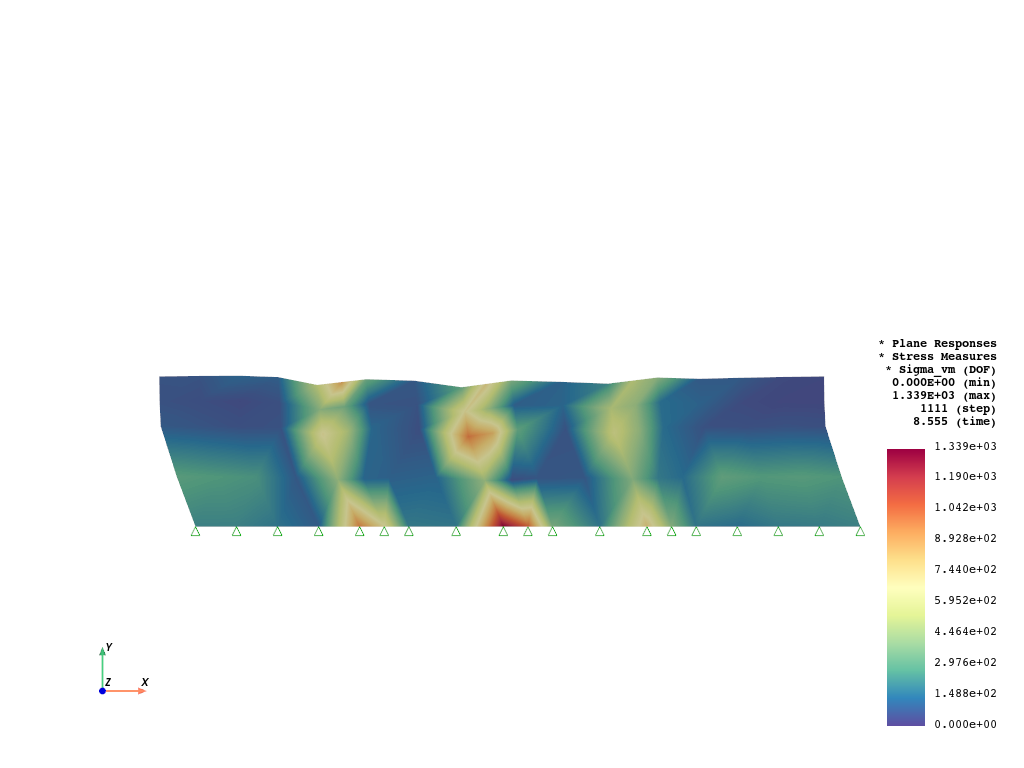

In [16]:
fig = opst.vis.pyvista.plot_unstruct_responses(
    odb_tag=1,
    slides=False,
    step="absMax",
    ele_type="Plane",
    resp_type="StressesAtNodes",
    resp_dof="sigma_vm",
    show_defo=True,
    defo_scale=1.5,
    show_model=True,
)
fig.show(jupyter_backend="jupyterlab")

### Plotting the deformation animation

In [17]:
opst.vis.pyvista.plot_nodal_responses_animation(
    odb_tag=1,
    framerate=50,  # Frames per second
    resp_type="disp",
    resp_dof=("UX", "UY"),
    show_defo=True,
    scale=1.5,
    savefig="nodal_disp_animation.mp4",
).close()

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

Animation has been saved to nodal_disp_animation.mp4!


In [18]:
from IPython.display import Video

Video("nodal_disp_animation.mp4", embed=True, width=600, height=400)  # Display the video in Jupyter Notebook

In [19]:
opst.vis.pyvista.plot_unstruct_responses_animation(
    odb_tag=1,
    framerate=50,  # Frames per second
    ele_type="Plane",
    resp_type="StressesAtNodes",
    resp_dof="sigma_vm",
    show_defo=True,
    defo_scale=1.5,
    show_model=True,
    savefig="stress_animation.mp4",
).close()

OPSTOOL ::  Loading response data from .opstool.output/RespStepData-1.nc ...

Animation has been saved as stress_animation.mp4!


In [20]:
Video("stress_animation.mp4", embed=True, width=600, height=400)